In [1]:
import numpy as np
import pandas as pd
rng = np.random.default_rng(12345)

from lymph.models import Unilateral
from lymixture import LymphMixture
from lymixture.utils import binom_pmf, late_binomial, normalize

dataset = pd.read_csv('../../data/mixture_model_data_combined.csv', header = [0,1,2],)
dataset_staging = dataset.copy()
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([0,1,2], 'early')
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([3,4], 'late')
dataset_staging = dataset_staging[~(dataset_staging['tumor']['1']['subsite'].str.startswith(('C00.4')))]

In [2]:
dataset_staging_main_groups = dataset_staging.copy()

# Reduce to only main subsite
dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')] = (
    dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')].str.replace(r'\..*', '', regex=True)
)

dataset_staging_main_groups['tumor']['1']['subsite'].value_counts()


subsite
C09    452
C12    227
C01    212
C10    169
C13    165
C02    158
C04     99
C05     61
C06     46
C03     45
Name: count, dtype: int64

In [3]:
graph = {
    ("tumor", "T"): ["I", "II", "III", "IV", "V"],
    ("lnl", "I"): ["II"],
    ("lnl", "II"): ["III"],
    ("lnl", "III"): ["IV"],
    ("lnl", "IV"): ["V"],
    ("lnl", "V"): [],
}

num_components = 3

mixture = LymphMixture(
    model_cls=Unilateral,
    model_kwargs={"graph_dict": graph},
    num_components=num_components,
)
mixture.load_patient_data(
    dataset_staging_main_groups,
    split_by=("tumor", "1", "subsite"),
    mapping=lambda x: x,
)


In [4]:
mixture.set_distribution("early", binom_pmf(np.arange(11), 10, 0.3))
mixture.set_distribution("late", late_binomial)
mixture.set_modality("diagnostic_consensus", 1., 1.)

In [5]:
mixture.subgroups.keys()

dict_keys(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C09', 'C10', 'C12', 'C13'])

Initialize random model parameters and latent variables/responsibilities.

In [7]:
from lymixture.em import expectation, maximization

params = {k: rng.uniform() for k in mixture.get_params()}
# params = {'0_TtoI_spread': 0.03628421062998108,
#  '0_TtoII_spread': 0.5694201218237662,
#  '0_TtoIII_spread': 0.024089493035651215,
#  '0_TtoIV_spread': 0.007991459519587112,
#  '0_TtoV_spread': 0.017450914601597076,
#  '0_ItoII_spread': 0.9999338930386481,
#  '0_IItoIII_spread': 0.15688650559245462,
#  '0_IIItoIV_spread': 0.21661193269679863,
#  '0_IVtoV_spread': 0.19104551579914725,
#  '0_C01_coef': 0.8691374019087204,
#  '0_C02_coef': 0.23708168027769252,
#  '0_C03_coef': 6.610696135189607e-05,
#  '0_C04_coef': 0.08631478356033348,
#  '0_C05_coef': 0.4127616455079167,
#  '0_C06_coef': 0.06420688335904512,
#  '0_C09_coef': 0.7059220652487983,
#  '0_C10_coef': 0.42406400369233466,
#  '0_C12_coef': 0.10152419687718993,
#  '0_C13_coef': 0.07816483651718796,
#  '1_TtoI_spread': 0.07414947628617403,
#  '1_TtoII_spread': 0.030268693680739776,
#  '1_TtoIII_spread': 0.021091202610107912,
#  '1_TtoIV_spread': 0.0055157383008690485,
#  '1_TtoV_spread': 0.00022366393680736492,
#  '1_ItoII_spread': 0.2583329498611006,
#  '1_IItoIII_spread': 0.06424572410183653,
#  '1_IIItoIV_spread': 6.610696135189607e-05,
#  '1_IVtoV_spread': 6.610696135189607e-05,
#  '1_C01_coef': 0.04420594277655354,
#  '1_C02_coef': 0.6480373436889144,
#  '1_C03_coef': 0.9998677860772962,
#  '1_C04_coef': 0.8652739492027672,
#  '1_C05_coef': 0.5871722475307314,
#  '1_C06_coef': 0.935727009679603,
#  '1_C09_coef': 0.11472405138393393,
#  '1_C10_coef': 0.23564700655269388,
#  '1_C12_coef': 1.447492052385202e-05,
#  '1_C13_coef': 2.1718230423004026e-05,
#  '2_TtoI_spread': 0.010073344388471975,
#  '2_TtoII_spread': 0.24376525135229166,
#  '2_TtoIII_spread': 0.12926227198554394,
#  '2_TtoIV_spread': 0.04242036182094629,
#  '2_TtoV_spread': 0.031015599151049643,
#  '2_ItoII_spread': 0.5327345742064853,
#  '2_IItoIII_spread': 0.2994676322459774,
#  '2_IIItoIV_spread': 0.06765884627581127,
#  '2_IVtoV_spread': 0.0741238401051394,
#  '2_C01_coef': 0.0866566553147261,
#  '2_C02_coef': 0.11488097603339309,
#  '2_C03_coef': 6.61069613518972e-05,
#  '2_C04_coef': 0.04841126723689926,
#  '2_C05_coef': 6.61069613518972e-05,
#  '2_C06_coef': 6.61069613518972e-05,
#  '2_C09_coef': 0.17935388336726776,
#  '2_C10_coef': 0.34028898975497146,
#  '2_C12_coef': 0.8984613282022862,
#  '2_C13_coef': 0.9218134452523891,
#  'late_p': 0.4170888932427761}
mixture.set_params(**params)
mixture.normalize_mixture_coefs()
latent = normalize(rng.uniform(size=mixture.get_resps().shape).T, axis=0).T

In [8]:
def to_numpy(params: dict[str, float]) -> np.ndarray:
    return np.array([p for p in params.values()])

Iterate the computation of the expectation value of the latent variables (E-step) and the maximization of the (complete) data log-likelihood w.r.t. the model parameters (M-step).

In [9]:
def check_convergence(params_history, likelihood_history, steps_back_list):
    current_params = params_history[-1]
    current_likelihood = likelihood_history[-1]
    for steps_back in steps_back_list:
        previous_params = params_history[-steps_back - 1]
        if np.allclose(to_numpy(current_params), to_numpy(previous_params)):
            print('stopped due to parameter similarity')
            return True  # Return True if any of the steps is close
        elif np.isclose(current_likelihood, likelihood_history[-steps_back - 1]):
            print('stopped due to likelihood similarity')
            return True
    return False

In [10]:
is_converged = False
count = 0
params_history = []
likelihood_history = []

# Number of steps to look back for convergence
look_back_steps = 3

while not is_converged:
    print(count)
    old_params = params
    latent = expectation(mixture, params)
    params = maximization(mixture, latent)
    
    # Append current params and likelihood to history
    params_history.append(params.copy())
    likelihood_history.append(mixture.likelihood())
    
    # Check if converged
    if count >= 3:  # Ensure enough history is available
        is_converged = check_convergence(params_history, likelihood_history,list(range(1,look_back_steps+1)))
    
    count += 1

0


KeyboardInterrupt: 

In [16]:
likelihood_history

[]

In [17]:
mixture.likelihood()

-3219.5794062694267

In [18]:
mixture._mixture_coefs

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13
0,0.827093,0.230797,0.000066,0.088625,0.409439,0.067622,0.690920,0.413313,0.101084,0.077280
1,0.049650,0.647523,0.999868,0.861142,0.590495,0.932311,0.114259,0.236068,0.000004,0.000036
2,0.123257,0.121680,0.000066,0.050233,0.000066,0.000066,0.194821,0.350619,0.898911,0.922684


In [19]:
mixture.get_params()

{'0_TtoI_spread': 0.03662827750895869,
 '0_TtoII_spread': 0.5959867059755846,
 '0_TtoIII_spread': 0.018715605023432443,
 '0_TtoIV_spread': 0.007823727583969192,
 '0_TtoV_spread': 0.01732098964565412,
 '0_ItoII_spread': 0.9999338930386481,
 '0_IItoIII_spread': 0.15995605637210591,
 '0_IIItoIV_spread': 0.22191862361308207,
 '0_IVtoV_spread': 0.19643368289041105,
 '0_C01_coef': 0.8270933663153645,
 '0_C02_coef': 0.23079698156870698,
 '0_C03_coef': 6.610696135189607e-05,
 '0_C04_coef': 0.08862540118148282,
 '0_C05_coef': 0.40943863291811444,
 '0_C06_coef': 0.06762246828464252,
 '0_C09_coef': 0.6909200902435061,
 '0_C10_coef': 0.4133132795616604,
 '0_C12_coef': 0.10108435874987988,
 '0_C13_coef': 0.07728027789707129,
 '1_TtoI_spread': 0.07407667853889147,
 '1_TtoII_spread': 0.02871298580523584,
 '1_TtoIII_spread': 0.02075607881574251,
 '1_TtoIV_spread': 0.005454894794473977,
 '1_TtoV_spread': 0.00016519322251897157,
 '1_ItoII_spread': 0.2629217365048911,
 '1_IItoIII_spread': 0.0660270464718

prevalence    0.823529
dtype: float64

In [67]:
subgroup = 'C01'
t_stage = 'early'
desired_lnl = 'III'
lnls = np.array(['I','II','III','IV','V'])

subgroup_combinations_short = pd.DataFrame(mixture.subgroups[subgroup].patient_data['_model']['diagnostic_consensus'].loc[mixture.subgroups[subgroup].patient_data['_model']['#']['t_stage'] == t_stage].value_counts()/(mixture.subgroups[subgroup].patient_data['_model']['#']['t_stage'] == t_stage).sum())
# Convert the Series to DataFrame
df = subgroup_combinations_short.reset_index()
df.columns = ['I', 'II', 'III', 'IV', 'V', 'prevalence']

# Convert boolean columns to tuples
df['predicted'] = df[['I', 'II', 'III', 'IV', 'V']].apply(lambda row: tuple(int(x) for x in row), axis=1)

# Drop the original boolean columns
df = df.drop(columns=['I', 'II', 'III', 'IV', 'V'])

import itertools

# Define the number of features (length of the combination list)
num_features = 5  # Update based on your data length

# Generate all possible combinations of binary values (0 or 1)
combinations = list(itertools.product([0, 1], repeat=num_features))

# Create a DataFrame with all combinations and default probability of 0
subgroup_combinations = pd.DataFrame(combinations, columns=[f'Feature_{i+1}' for i in range(num_features)])
subgroup_combinations['predicted'] = subgroup_combinations.apply(lambda row: tuple(row), axis=1)
subgroup_combinations.drop(columns=[f'Feature_{i+1}' for i in range(num_features)], inplace=True)
# Merge with the existing probabilities
subgroup_combinations = pd.merge(subgroup_combinations, df, on='predicted', how='left').fillna(0)
subgroup_combinations.drop(columns=['predicted'], inplace=True)

mixture.state_dist(subgroup=subgroup)
df = pd.DataFrame(np.array([mixture.state_dist(subgroup=subgroup,t_stage=t_stage)]), columns = [str(col) for col in mixture.components[0].graph.state_list])
df = df.T
df.columns = ['predicted']
subgroup_combinations['index'] = df.index
subgroup_combinations.set_index('index', inplace=True)
df_final = pd.concat([subgroup_combinations, df],axis = 1)

lnl_index = np.where(lnls == desired_lnl)[0][0]
indices = []
for i, state in enumerate(mixture.components[0].graph.state_list):
    if state[lnl_index] == 1:
        indices.append(i)
print(desired_lnl, subgroup_combinations.iloc[indices].sum()*100,)

df_final*100

III prevalence    32.258065
dtype: float64


,prevalence,predicted
[0 0 0 0 0],12.903226,17.164205
[0 0 0 0 1],0.000000,0.489337
[0 0 0 1 0],0.000000,0.449459
[0 0 0 1 1],0.000000,0.069999
[0 0 1 0 0],1.075269,1.568924
[0 0 1 0 1],0.000000,0.117520
[0 0 1 1 0],0.000000,0.274302
[0 0 1 1 1],0.000000,0.054992
[0 1 0 0 0],49.462366,44.468461
[0 1 0 0 1],1.075269,2.368112


## Load/Save Data

In [15]:
import pickle 

# with open('params_I_to_V_ipsi_4_comp.pkl', 'wb') as f:
#     pickle.dump(params, f)
        
with open('params_I_to_V_ipsi_3_comp.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
params = loaded_dict
mixture.set_params(**loaded_dict)
mixture.normalize_mixture_coefs()
mixture.set_resps(expectation(mixture, loaded_dict))
mixture.likelihood()

-3219.5794062694267

In [84]:
mixture.get_mixture_coefs()

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13
0,0.827093,0.230797,0.000066,0.088625,0.409439,0.067622,0.690920,0.413313,0.101084,0.077280
1,0.049650,0.647523,0.999868,0.861142,0.590495,0.932311,0.114259,0.236068,0.000004,0.000036
2,0.123257,0.121680,0.000066,0.050233,0.000066,0.000066,0.194821,0.350619,0.898911,0.922684


## Mixture evaluation

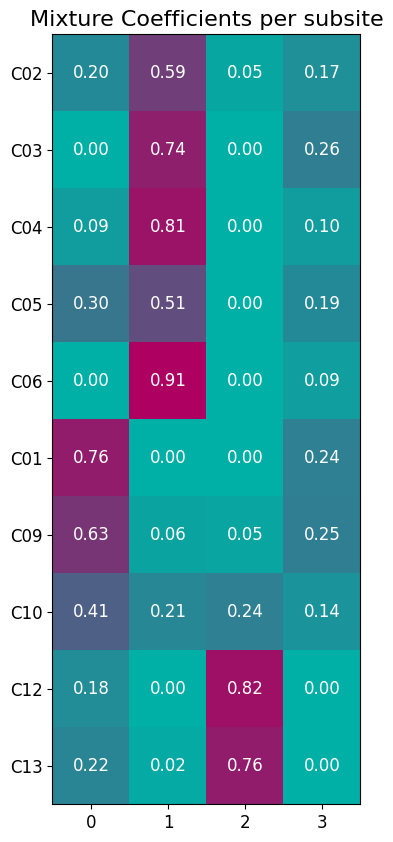

In [98]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

# USZ colors
usz_blue = '#005ea8'
usz_green = '#00afa5'
usz_red = '#ae0060'
usz_orange = '#f17900'
usz_gray = '#c5d5db'

# colormaps
white_to_blue  = LinearSegmentedColormap.from_list("white_to_blue", 
                                                   ["#ffffff", usz_blue], 
                                                   N=256)
white_to_green = LinearSegmentedColormap.from_list("white_to_green", 
                                                   ["#ffffff", usz_green], 
                                                   N=256)
green_to_red   = LinearSegmentedColormap.from_list("green_to_red", 
                                                   [usz_green, usz_red], 
                                                   N=256)

h = usz_gray.lstrip('#')
gray_rgba = tuple(int(h[i:i+2], 16) / 255. for i in (0, 2, 4)) + (1.0,)
tmp = LinearSegmentedColormap.from_list("tmp", [usz_green, usz_red], N=128)

matrix = mixture.get_mixture_coefs()[['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13']]

# Transpose the matrix to rotate by 90°
matrix_rotated = matrix.T

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 10))

# Display the rotated matrix using imshow
cax = ax.imshow(matrix_rotated.values, cmap=tmp, origin='upper')

# Loop over the data and create text annotations
for i in range(matrix_rotated.shape[0]):  # Rows (previously columns)
    for j in range(matrix_rotated.shape[1]):  # Columns (previously rows)
        value = matrix_rotated.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", 
                color="white", fontsize=12)


# Optional: Set axis labels and title
ax.set_xticks(range(matrix_rotated.shape[1]))
ax.set_xticklabels(matrix.index, fontsize = 12)  # Original row labels
ax.set_yticks(range(matrix_rotated.shape[0]))
ax.set_yticklabels(matrix.columns, fontsize = 12)  # Original column labels
ax.set_title("Mixture Coefficients per subsite", fontsize = 16)
plt.show()
